In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## **Save Models and Make Predictions**

Selecting a time series forecasting model is just the beginning. Using the chosen model in practice can pose challenges, including data transformations and storing the model parameters on disk.

**Process for Making a Prediction**

Once you can build and tune forecast models for your data, the process of making a prediction involves the following steps:

1. *Model Selection:* This is where you choose a model and gather evidence and support to defend the decision.
2. *Model Finalization:* The chosen model is trained on all available data and saved to file for later use.
3. *Forecasting:* The saved model is loaded and used to make a forecast.
4. *Model Update:* Elements of the model are updated in the presence of new observations.

In [3]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import  AutoReg

# create difference tranform of the dataset
def difference(dataset):
    diff = []
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return np.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

series = pd.read_csv("daily-total-female-births.csv", header=0,index_col=0,parse_dates=True,squeeze=True)

# Split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]

# train autoregression
model = AutoReg(train,lags=6)
model_fit = model.fit()
window = len(model_fit.ar_lags)
coef = model_fit.params

# Walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = []

for t in range(len(test)):
    yhat = predict(coef,history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
rmse = mean_squared_error(test,predictions,squared=False)
print(f"Test RMSE:{np.round(rmse,4)}")

Test RMSE:7.2592


Text(0.5, 1.0, 'Line plot of expected values (blue) and AR model predictions (red)')

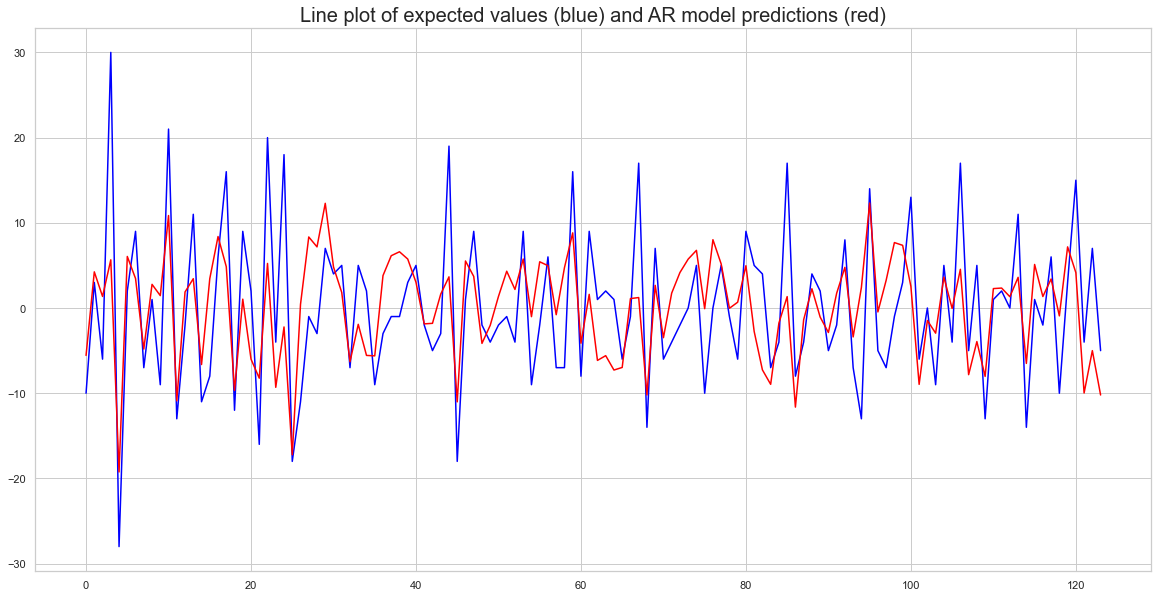

In [5]:
fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style="whitegrid")

sns.lineplot(data=test,color='blue')
sns.lineplot(data=predictions,color='red')
ax.set_title("Line plot of expected values (blue) and AR model predictions (red)",fontdict={'fontsize':20})

**Finalize and Save Time Series Forecast Model**

The Statsmodels implementations of time series models do provide built-in capability to save and load models by calling save() and load() on the fit ARResults object. For example, the code below will train an AR(6) model on the entire Female Births dataset and save it using the built-in save() function, which will essentially pickle the ARResults object.

The differenced training data must also be saved, both for the lag variables needed to make a prediction, and for knowledge of the number of observations seen, required by the predict() function of the ARResults object. Finally, we need to be able to transform the differenced dataset back into the original form. To do this, we must keep track of the last actual observation. This is so that the predicted differenced value can be added to it.

In [7]:
# create difference tranform of the dataset
def difference(dataset):
    diff = []
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return np.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

series = pd.read_csv("daily-total-female-births.csv", header=0,index_col=0,parse_dates=True,squeeze=True)

# Split dataset
X = difference(series.values)


# train autoregression
model = AutoReg(X,lags=6)
model_fit = model.fit()

# Save model to file
model_fit.save('ar_model.pkl')

# Save the differenced dataset
np.save("ar_data.npy",X)

# Save the last ob
np.save("ar_obs.npy",[series.values[-1]])

This code will create a file ar model.pkl that you can load later and use to make predictions. The entire differenced training dataset is saved as ar data.npy and the last observation is saved in the file ar obs.npy as an array with one item. 

The NumPy save() function is used to save the differenced training data and the observation. The load() function can then be used to load these arrays later. The snippet below will load the model, differenced data, and last observation.

In [8]:
# Load the AR model file
from statsmodels.tsa.ar_model import AutoRegResults
loaded = AutoRegResults.load('ar_model.pkl')
print(loaded.params)
data = np.load("ar_data.npy")
last_ob = np.load("ar_obs.npy")
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[50]


I think this is good for most cases, but is also pretty heavy. You are subject to changes to the Statsmodels API. My preference is to work with the coefficients of the model directly, as in the case above, evaluating the model using a rolling forecast. In this case, you could simply store the model coefficients and later load them and make predictions. The example below saves just the coefficients from the model, as well as the minimum differenced lag values required to make the next prediction and the last observation needed to transform the next prediction made.

**I skipped the code for this but you can review it in page 252**

**Make a Time Series Forecast**

Making a forecast involves loading the saved model and estimating the observation at the next time step. If the ARResults object was serialized, we can use the predict() function to predict the next time period. The example below shows how the next time period can be predicted. The model, training data, and last observation are loaded from file.

The period is specified to the predict() function as the next time index after the end of the training data set. This index may be stored directly in a file instead of storing the entire training data, which may be an efficiency. The prediction is made, which is in the context of the differenced dataset. To turn the prediction back into the original units, it must be added to the last known observation.

In [21]:
# Load model
# https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/
# load model
model = AutoRegResults.load('ar_model.pkl')
data = np.load('ar_data.npy')
last_ob = np.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = predictions[0] + last_ob[0]
print(f'Prediction: {yhat}')

Prediction: 46.75521111746649


**Update Forecast Model**

Once the next real observation is made available, we must update the data associated with the model. Specifically, we must update:
1. The differenced training dataset used as inputs to make the subsequent prediction.
2. The last observation, providing a context for the predicted differenced value.

Let's assume the next actual observation in the series was 48. The new observation must first be differenced with the last observation. It can then be stored in the list of differenced observations. Finally, the value can be stored as the last observation. In the case of the stored AR model, we can update the ar data.npy and ar obs.npy files.

In [36]:
# Get real observation
observation = 48

# Load the saved data
data = np.load('ar_data.npy')
last_ob = np.load('ar_obs.npy')

# Update and save differenced observation
diffed = observation - last_ob[0]
data = np.append(data, [diffed], axis=0)
np.save('ar_data.npy', data)
# Update and save real observation
last_ob[0] = observation
np.save('ar_obs.npy',last_ob)
# print(last_ob)

[48]


We have focused on one-step forecasts. These methods would work just as easily for multi-step forecasts, by using the model repetitively and using forecasts of previous time steps as input lag values to predict observations for subsequent time steps.

**Extensions**

Generally, it is a good idea to keep track of all the observations. This will allow you to:
- Provide a context for further time series analysis to understand new changes in the data.
- Train a new model in the future on the most recent data.
- Back-test new and different models to see if performance can be improved.

For small applications, perhaps you could store the raw observations in a file alongside your model. It may also be desirable to store the model coefficients and required lag data and last observation in plain text for easy review. For larger applications, perhaps a database system could be used to store the observations.